# ABS Quarterly National Accounts 5206

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Set-up-some-constants-we-will-use-across-all-plots" data-toc-modified-id="Set-up-some-constants-we-will-use-across-all-plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Set-up some constants we will use across all plots</a></span></li><li><span><a href="#Growth-charts---based-on-seasonally-adjusted-series" data-toc-modified-id="Growth-charts---based-on-seasonally-adjusted-series-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Growth charts - based on seasonally adjusted series</a></span></li><li><span><a href="#Four-quarter-rolling-totals---original-series" data-toc-modified-id="Four-quarter-rolling-totals---original-series-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Four quarter rolling totals - original series</a></span></li><li><span><a href="#Savings" data-toc-modified-id="Savings-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Savings</a></span></li><li><span><a href="#Gross-Value-Added-(GVA)-by-Industry" data-toc-modified-id="Gross-Value-Added-(GVA)-by-Industry-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Gross Value Added (GVA) by Industry</a></span></li><li><span><a href="#Household-Final-Consumption-Expenditure" data-toc-modified-id="Household-Final-Consumption-Expenditure-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Household Final Consumption Expenditure</a></span></li><li><span><a href="#Taxes" data-toc-modified-id="Taxes-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Taxes</a></span></li><li><span><a href="#Government-Benefits-Payments" data-toc-modified-id="Government-Benefits-Payments-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Government Benefits Payments</a></span></li></ul></li><li><span><a href="#Save-nominal-GDP-(it-is-useful-elsewhere)" data-toc-modified-id="Save-nominal-GDP-(it-is-useful-elsewhere)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save nominal GDP (it is useful elsewhere)</a></span></li><li><span><a href="#Finished" data-toc-modified-id="Finished-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import pathlib  
import calendar
import re

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    get_identifier,
    plot_Qgrowth,
    recalibrate_series,
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '5206'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
abs = get_ABS_meta_and_data(catalogue_id)
if abs is None:
    sys.exit(-1)

Retrieving zip-file from cache ./ABS_CACHE/-statistics-economy-national-accounts-australian-national-accounts-national-income-expenditure-and-product-jun-2022-All_time_series_workbooks.zip


## Plot

### Set-up some constants we will use across all plots

In [4]:
meta = abs[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)
CVM = 'Chain volume measures'

### Growth charts - based on seasonally adjusted series

Gross domestic product:


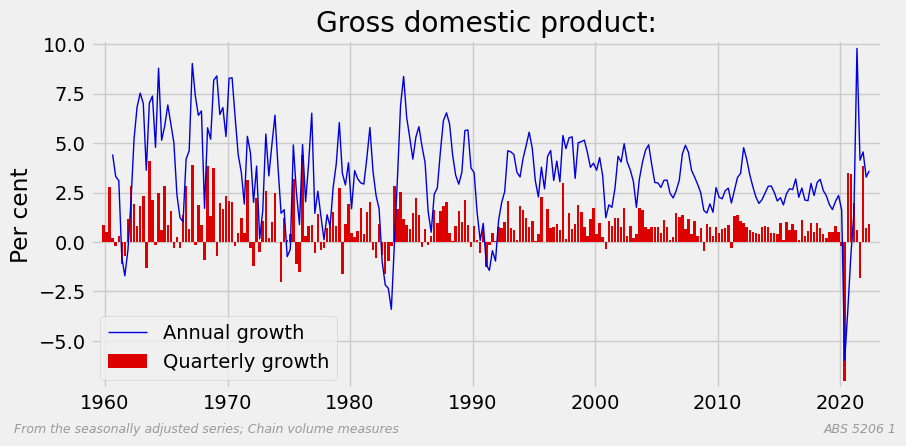

Gross domestic product:


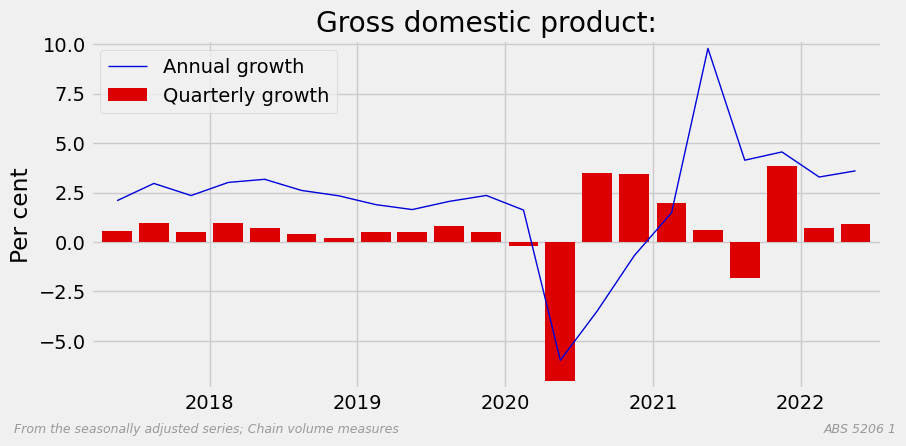

Gross value added market sector:


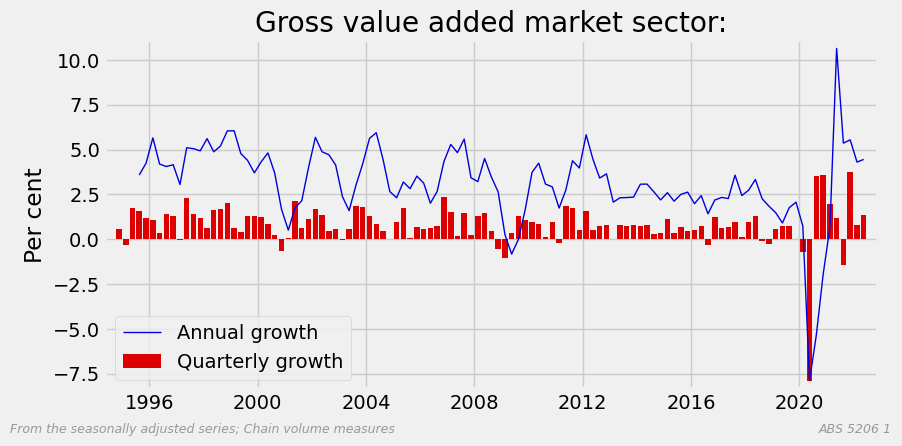

Gross value added market sector:


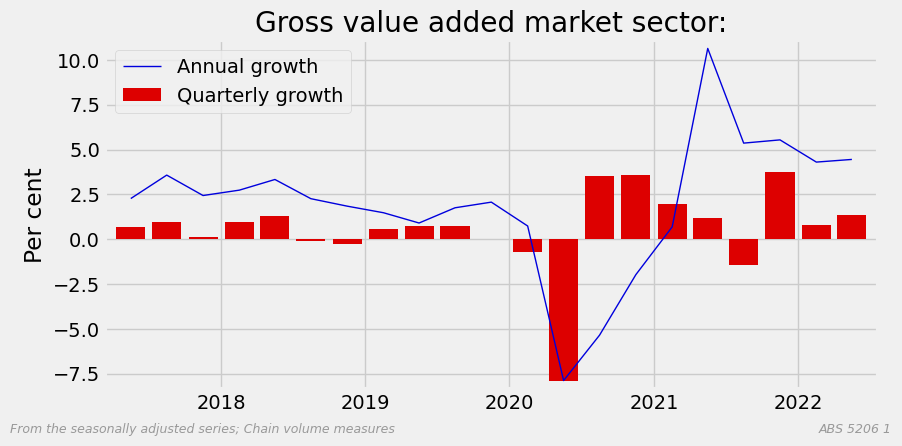

Net domestic product:


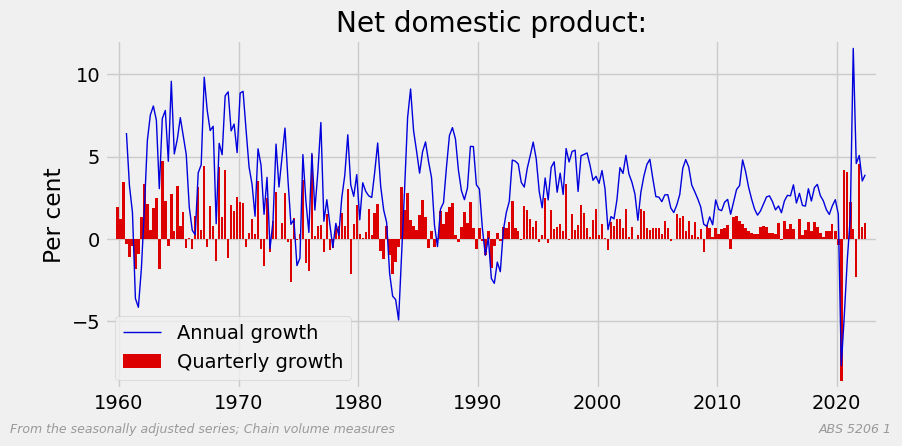

Net domestic product:


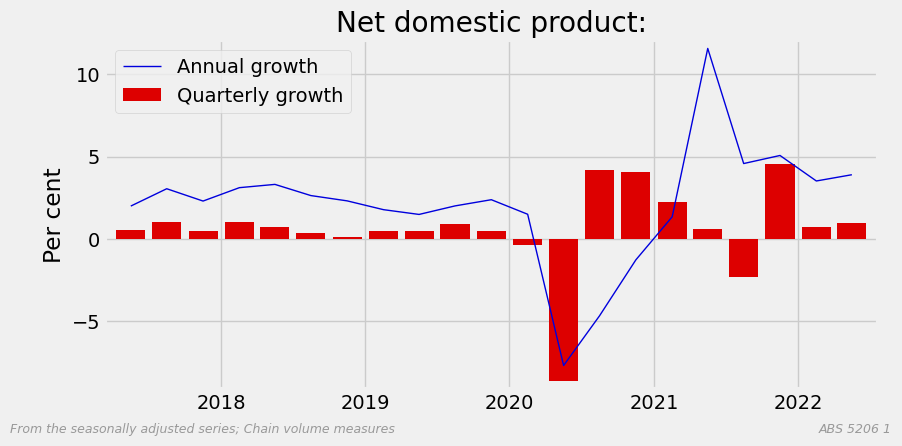

Real gross domestic income:


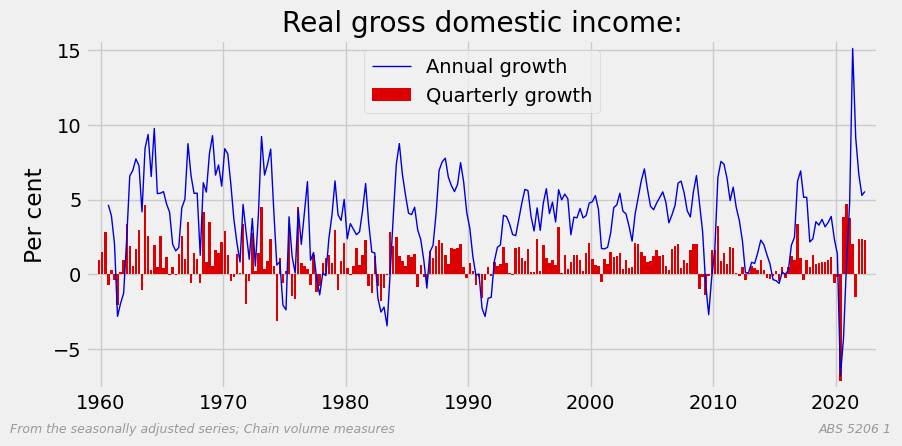

Real gross domestic income:


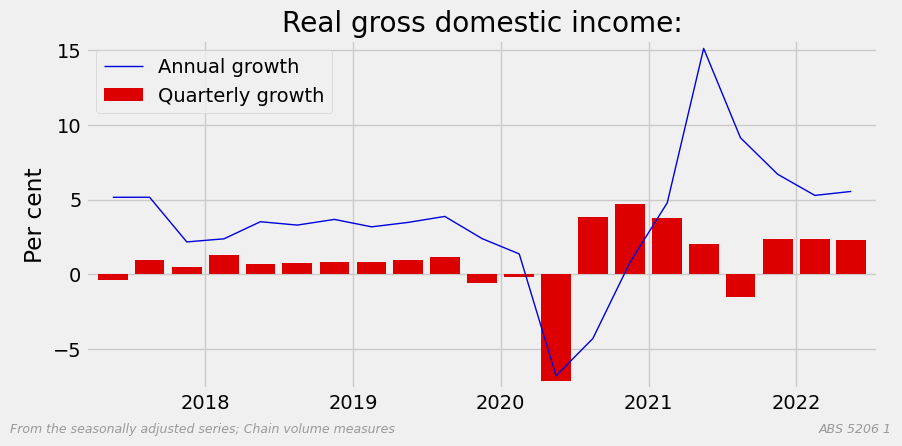

Real gross national income:


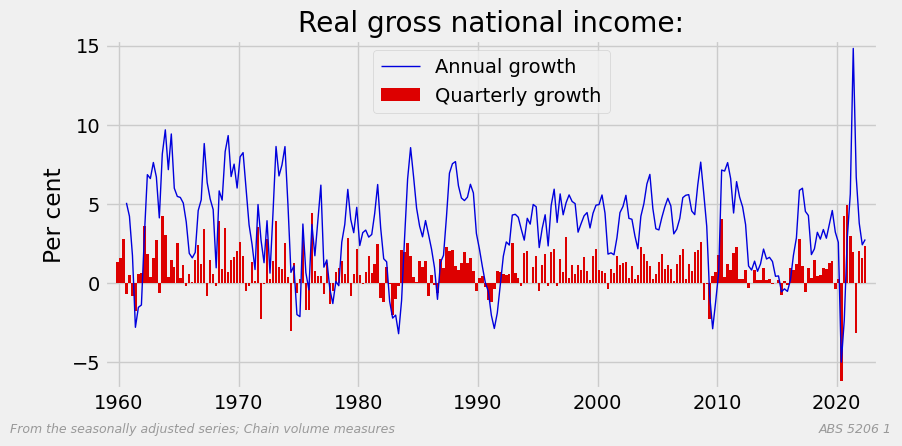

Real gross national income:


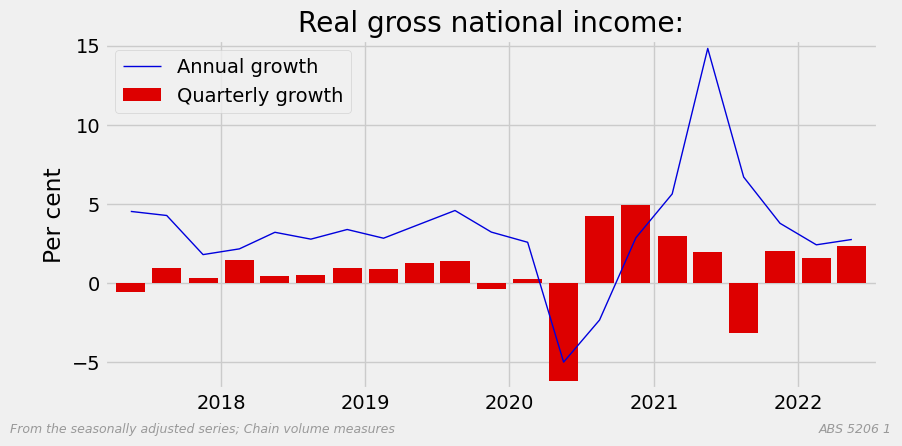

Real net national disposable income:


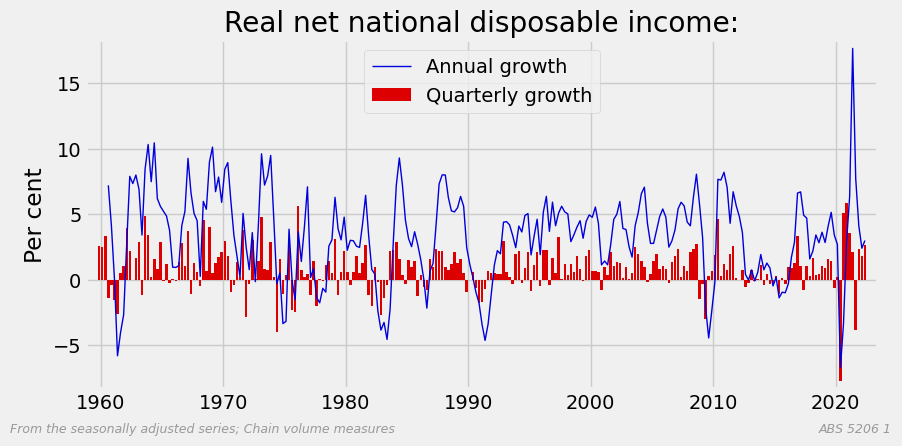

Real net national disposable income:


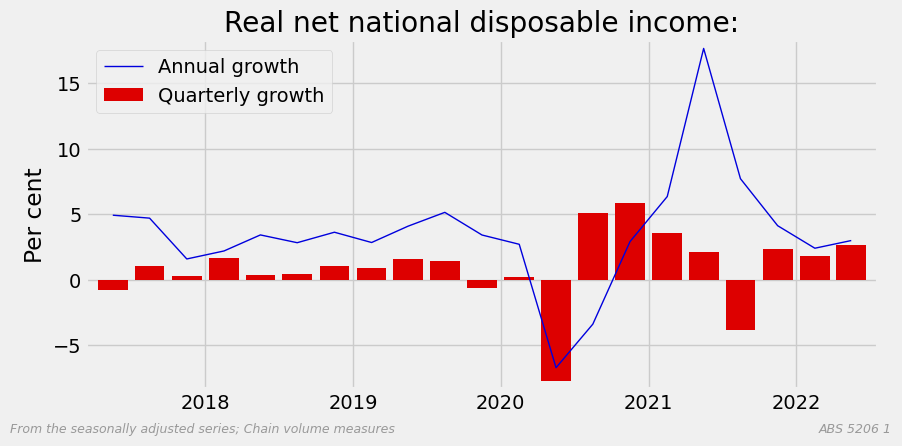

In [5]:
# identify available headline series from metadata
table = '1'
data = abs[table]

series_type = 'Seasonally Adjusted'
headline_plots = meta[
    (meta['Table'] == table) &
    (meta['Series Type'] == series_type) &
    (meta['Unit'] == '$ Millions') &
    (meta['Data Item Description'].str.contains(CVM))    
]['Data Item Description']

for description in headline_plots:
    
    # identify data
    series, units = get_identifier(meta, description,
                               series_type, table) 
    units = units + ' / Quarter' # make this clear
    plt_data, units = recalibrate_series(data[series], units)
    
    # plot
    for plot_from, plot_tag in zip(plot_times, plot_tags):

        title = description.replace(';', '').replace(CVM, '').strip()
        print(title)
        
        # plot raw quarterly data
        plot_data = plt_data
        if plot_from:
            plot_data = plt_data[plt_data.index >= plot_from]
        ax = plot_data.plot(lw=2, color="#dd0000")
        finalise_plot(ax, 
            title, units, plot_tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=f'{series_type.lower()} series'
        )
        
        # plot quarterly and through the year growth
        plot_Qgrowth(data[series].copy(), 
                     title, plot_from, 
                     plot_tag, CHART_DIR,
                     rfooter=f'{source} {table}',
                     lfooter=f'From the {series_type.lower()} series; {CVM}',
                     show=True,
                    )

### Four quarter rolling totals - original series

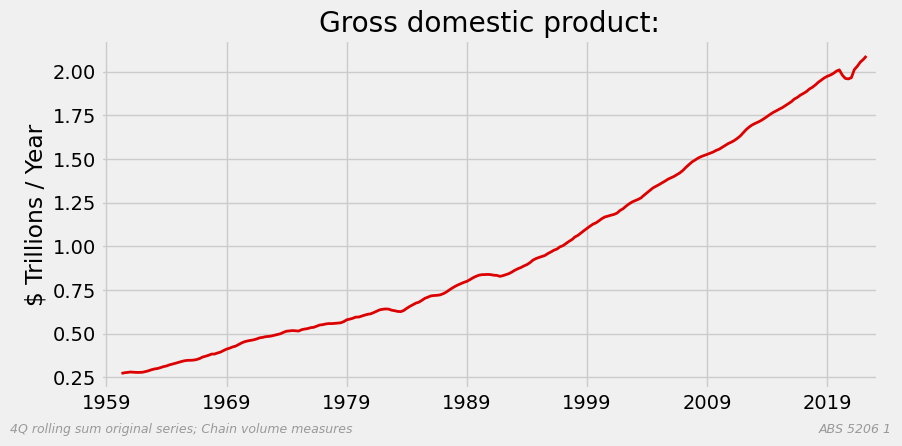

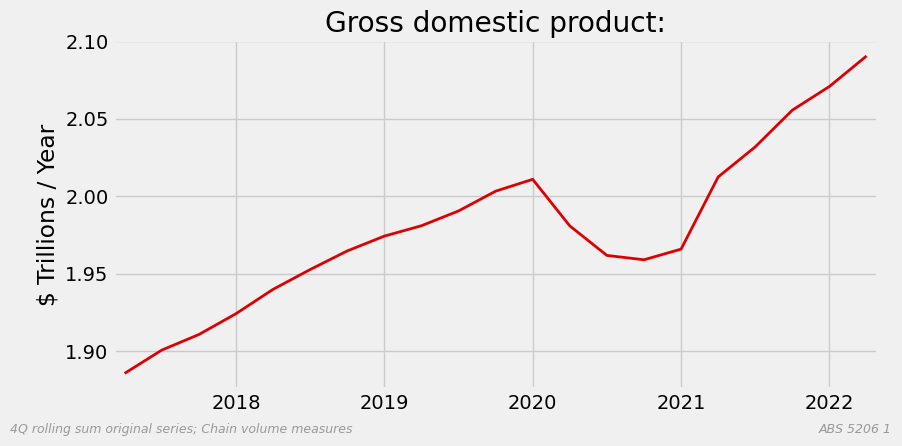

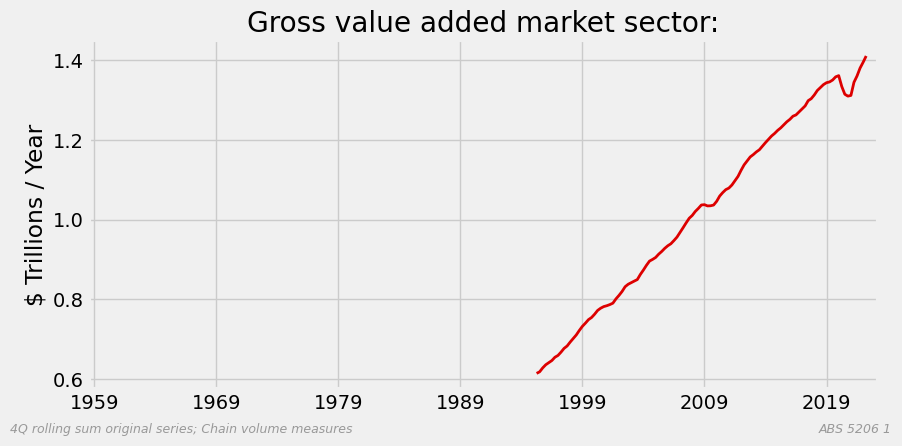

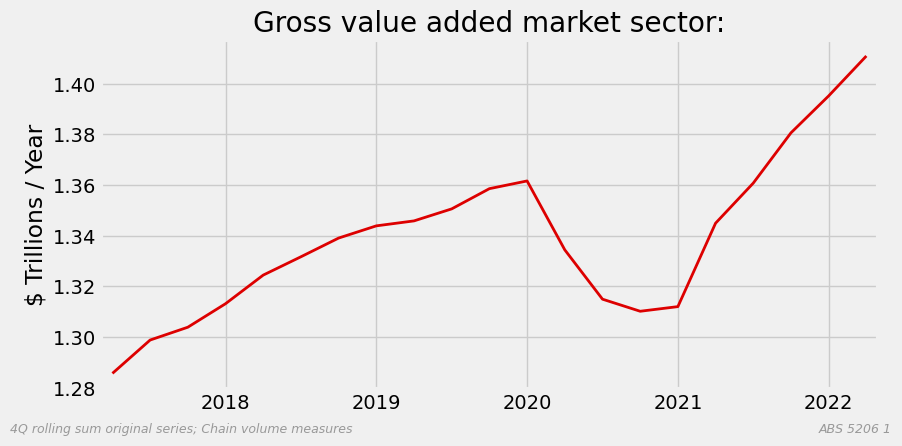

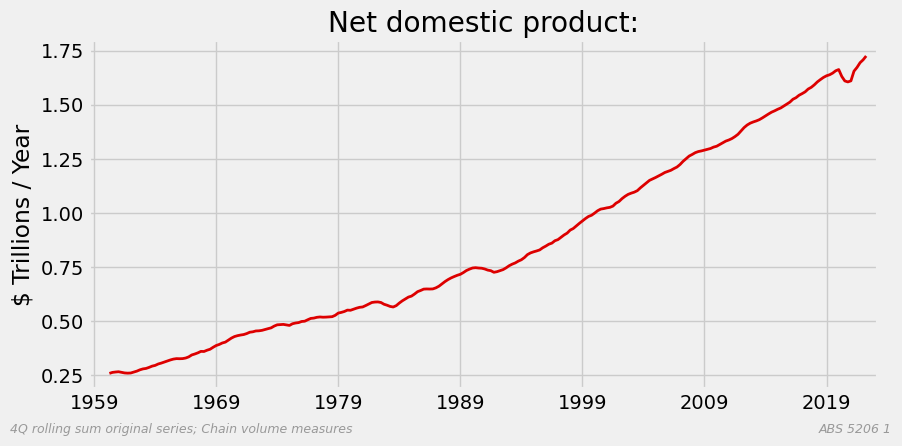

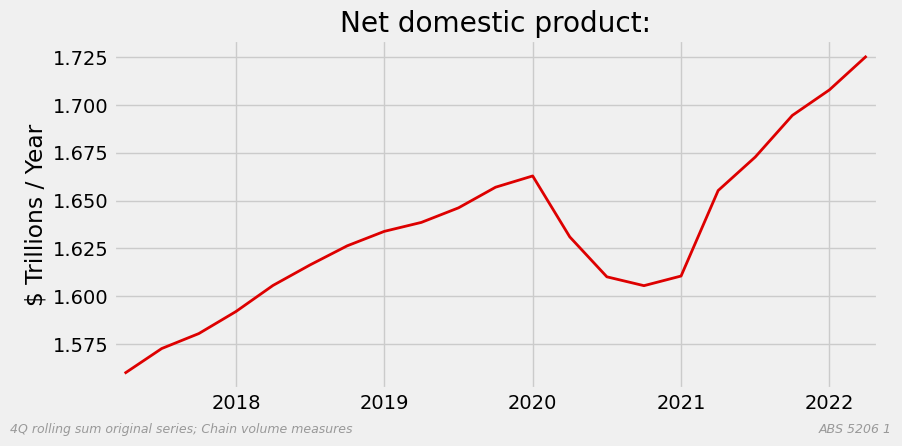

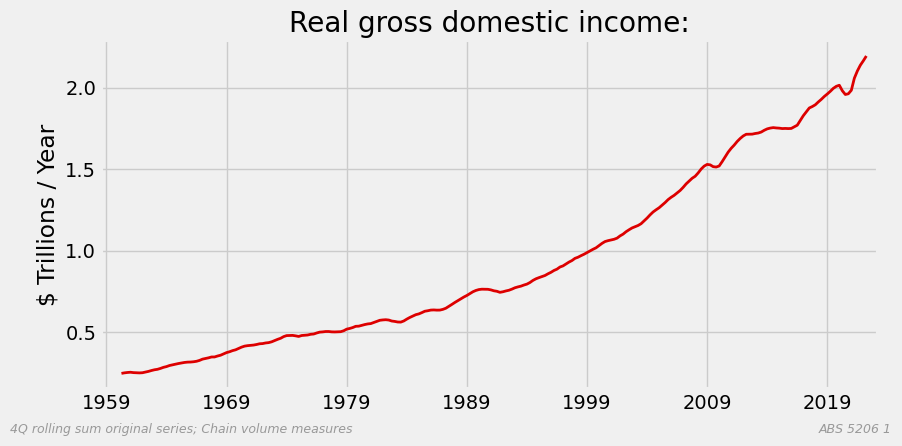

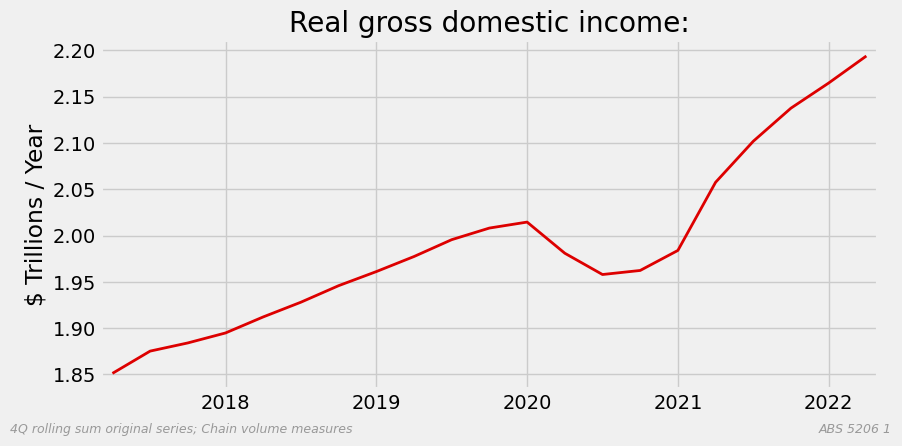

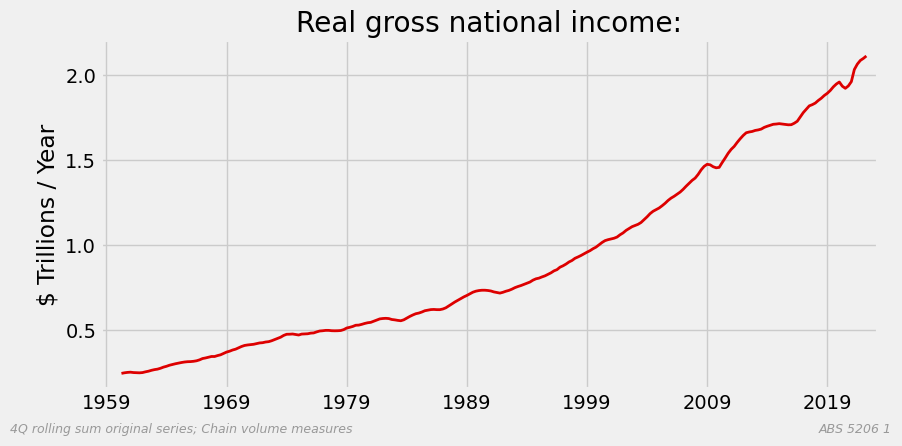

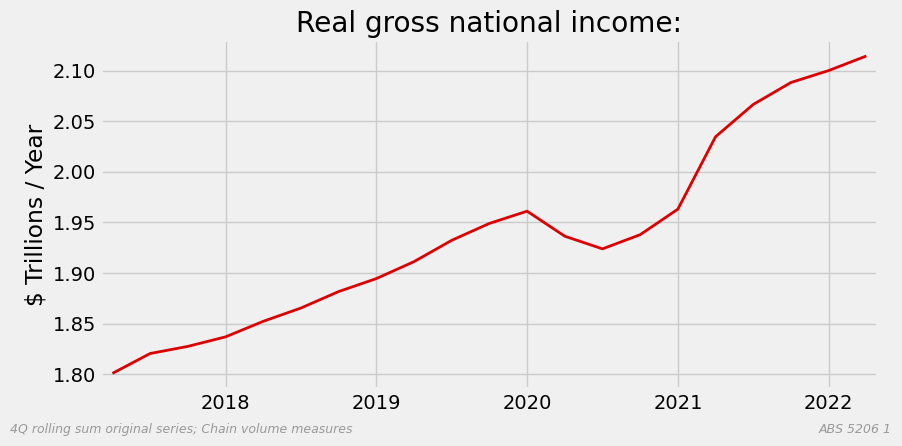

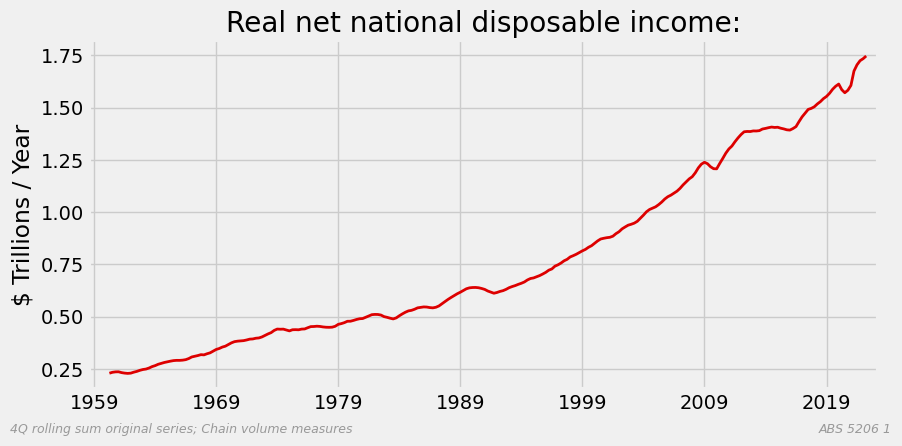

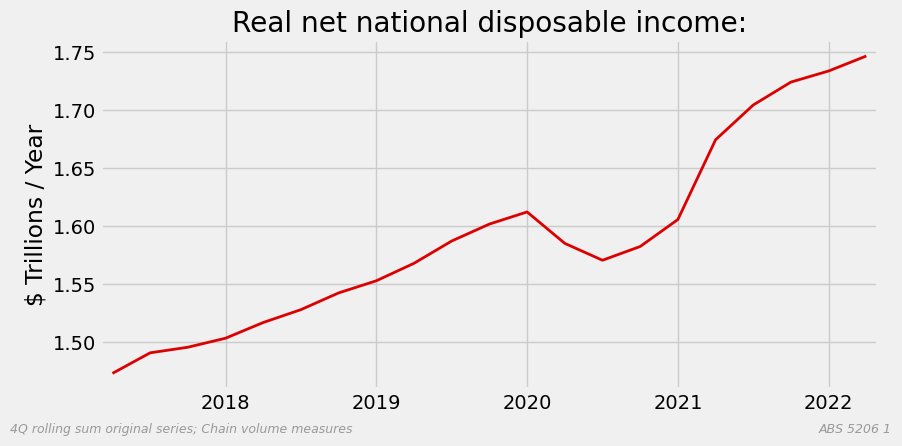

In [6]:
# uses same series from previous cell
table = '1'
data = abs[table]
series_type = "Original"
for description in headline_plots:

    series, units = get_identifier(meta, description,
                               series_type, table)
    units = f'{units} / Year'
    rolling4Q, units = recalibrate_series(data[series].rolling(4).sum(), units)

    for plot_time, plot_tag in zip(plot_times, plot_tags):
        plot_data = rolling4Q
        if plot_time:
            plot_data = rolling4Q[rolling4Q.index >= plot_time]
        ax = plot_data.plot(lw=2, color="#dd0000")
        
        title = description.replace(';', '').replace(CVM, '').strip()
        
        finalise_plot(ax, title, units, plot_tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=f'4Q rolling sum {series_type.lower()} series; {CVM}',
            show=True,
        )

### Savings

In [7]:
for table in ['1', '11']:

    table = '11'
    data = abs[table]

    series_type = 'Seasonally Adjusted'
    headline_plots = meta[
        (meta['Table'] == table) &
        (meta['Series Type'] == series_type) &
        (meta['Data Item Description'].str.contains("saving"))    
    ]['Data Item Description']

    for description in headline_plots:
        # identify data
        series, units = get_identifier(meta, description,
                               series_type, table) 
        units = units + ' / Quarter'
        plotable, units = recalibrate_series(data[series], units)
    
        for plot_from, plot_tag in zip(plot_times, plot_tags):

            title = description.replace(' ;', '')
        
            # plot raw quarterly data
            plot_data = plotable
            if plot_from:
                plot_data = plotable[plotable.index >= plot_from]
            ax = plot_data.plot(lw=2, color="#dd0000")
            finalise_plot(ax, 
                title, units, plot_tag, CHART_DIR,
                rfooter=f'{source} {table}',
                lfooter=f'{series_type.lower()} series',
                          #show=True,
            )

### Gross Value Added (GVA) by Industry

In [8]:
# identify available series from metadata
table = '6'
data = abs[table]

series_type = 'Seasonally Adjusted'
industries = meta[
    (meta['Table'] == table) &
    (meta['Series Type'] == series_type) &
    (meta['Unit'] == '$ Millions') # limit to money
]['Data Item Description']
industry_start = pd.Timestamp('1974-09-01')

for industry in industries:

    # get data
    series, units = get_identifier(meta, industry,
                               series_type, table)
    units = f'{units}  / Quarter'
    plotable, units = recalibrate_series(data[series], units)

    # plot
    for start, tag in zip(plot_times, plot_tags):
        subset = plotable[plotable.index >= start] if start else plotable
        subset = subset[subset.index >= industry_start]
        ax = subset.plot(lw=2, color="#dd0000")

        # we limit subgroup titles to keep the width
        # within what would fit on the top of a plot
        title = industry.replace(' ;', '').strip()
        if not title.endswith(")"):
            title = re.sub("^[^\(]+\(", "(", title)
        title = f' GVA: {title}'

        finalise_plot(ax, title, units, tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=(f'{series_type.capitalize()}, '
                     f'{CVM.lower()}')
        )

###  Household Final Consumption Expenditure

In [9]:
# identify available series from metadata
table = '8'
data = abs[table]
series_type = 'Seasonally Adjusted'
hfce = meta[
    (meta['Table'] == table) &
    (meta['Series Type'] == series_type) &
    (meta['Unit'] == '$ Millions') & # limit to money
    (meta['Data Item Description'].str.contains(CVM))
]['Data Item Description']

for description in hfce:
    
    # get data
    series, units = get_identifier(meta, description,
                                   series_type, table)
    units = f'{units} / Quarter'
    plotable, units = recalibrate_series(data[series], units)
    
    # plot
    for start, tag in zip(plot_times, plot_tags):
        subset = plotable[plotable.index >= start] if start else plotable
        ax = subset.plot(lw=2, color="#dd0000")
        
        title = description.replace(f': {CVM} ;', '')
        title = f'Household spending: {title}'
        
        finalise_plot(ax, title, units, tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=(f'{series_type.capitalize()}, '
                     f'{CVM.lower()}')
        )

### Taxes

In [10]:
# identify available series from metadata
table = '22'
data = abs[table]
series_type = 'Seasonally Adjusted'
tax_plots = meta[
    (meta['Table'] == table) &
    (meta['Series Type'] == series_type) 
]['Data Item Description']

for plot in tax_plots:
    
    # data capture
    ident, units = get_identifier(meta, plot, series_type, table)
    units = f'{units} / Qtr'
    series = data[ident]
    
    series, units = recalibrate_series(series, units)
    
    series = series[series.index >= RECENT]
    if series.isna().all():
        # don't plot empty series
        continue
    
    # plot
    ax = series.plot(lw=2, color="#dd0000")
    title = plot.replace(' ;', '')
    finalise_plot(ax, title, 
                  f'{units} (Current Prices)', 
                  'govt-tax', CHART_DIR,
                  rfooter=f'{source} {table}',
                  lfooter=f'{series_type.capitalize()} series')

### Government Benefits Payments

In [11]:
table = '23'
data = abs[table]
series_type = 'Original'
plots_payments = meta[
    (meta['Table'] == table) &
    (meta['Series Type'] == series_type) 
]['Data Item Description']

for plot in plots_payments:
    
    # get data
    ident, units = get_identifier(meta, plot, series_type, table)
    units = f'{units} / Qtr'
    series = data[ident]
    
    series, units = recalibrate_series(series, units)
    
    series = series[series.index >= RECENT]
    if series.isna().all():
        # don't plot empty series
        continue

    # plot
    ax = series.plot(lw=2, color="#dd0000")
    
    # - from ABS description to plot title
    title = plot.replace('General government - National ;  ',
                         'Federal Govt - ')
    title = title.replace('General government - State and local ;  ',
                         'State or Local Govt - ')
    title = title.replace('General government ;  ',
                         'All Govt - ')
    title = title.replace(' ;', '')
    
    finalise_plot(ax, title, f'{units} (Current Prices)', 
                  'govt-spending', CHART_DIR,
                  rfooter=f'{source} {table}',
                  lfooter=f'{series_type.capitalize()} series')
        

## Save nominal GDP (it is useful elsewhere)

In [12]:
NOMINAL_GDP_DIR = "./DATA/"
pathlib.Path(NOMINAL_GDP_DIR).mkdir(parents=True, exist_ok=True)
NOMINAL_GDP_CSV = NOMINAL_GDP_DIR + 'nominal_gdp.csv'

table = '24' # Selected Analytical Series
data = abs[table]
series_type = 'Original'
descriptions = [
    'Non-farm ;  Gross domestic product: Current prices ;',
    'Farm ;  Gross domestic product: Current prices ;',
]
frame = {}
for series in descriptions:
    ident, units = get_identifier(meta, series, series_type, table)
    frame[series] = data[ident]
print(f'From table {table}: {units}')
frame = pd.DataFrame(frame)
frame['Total quarterly'] = frame.sum(axis=1)
frame['Rolling Annual'] = frame['Total quarterly'].rolling(4).sum()

table = '34' # Key Aggregates and analytical series, Annual
data = abs[table]
series = 'Gross domestic product: Current prices ;'
ident, units = get_identifier(meta, series, series_type, table)
print(f'From table {table}: {units}')
frame[f'Annual {series}'] =  data[ident]

frame.to_csv(NOMINAL_GDP_CSV)

From table 24: $ Millions
From table 34: $ Millions


## Finished

In [13]:
print('Finished')

Finished
